# Определение возраста покупателей

## Исследовательский анализ данных

In [6]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from PIL import Image
import random

In [7]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [8]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [9]:
labels.shape

(7591, 2)

In [10]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


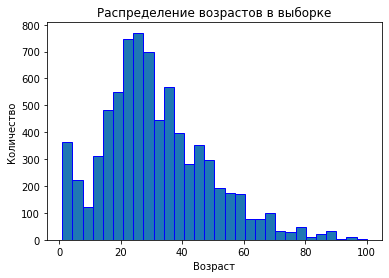

In [11]:
plt.hist(labels['real_age'], bins=30, edgecolor='b')
plt.title('Распределение возрастов в выборке')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.show()

Функция выводит рандомные фотографии из датасета для ознакомления. 

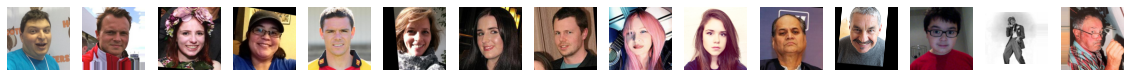

In [12]:
final_directory ='/datasets/faces/final_files/'

fig=plt.figure(figsize=(20, 5))
random_i = random.sample(range(len(labels)), 15)

for x,idx in enumerate(random_i):
    img_photo=final_directory + labels['file_name'][idx]
    img = Image.open(img_photo)
    ax = fig.add_subplot(1, 15, x + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

Выводы:

1) Всего 7591 штук фотографий в датасете.

2) Распределение возрастов такое что, в основном от 18 до 40 лет. Также имеются в достаточном количестве фотографий детей до 18 лет. Максимальный возвраст людей на фото 100 лет. 

3) В датасете разные фотографии людей - от художественных и профессиональных черно-белых портретов до фотографий в анфас на качестве начального-любительского уровня. Некоторые смазаны или имеют какие-то  объекты на фото 

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

def load_train(path, batch_size=32, seed=42):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='raw',
        subset='training',
        seed=seed)

    return train_gen_flow

def load_test(path, batch_size=32, seed=42):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224), #максимальный размер для модели
        batch_size=batch_size,
        class_mode='raw',
        subset='validation',
        seed=seed)

    return test_gen_flow

def create_model(input_shape, learning_rate=0.0001):
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=12, steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model
```

Добавление слоев и увеличение количества нейронов только приносилу худшее значение MSE от 8 до 12. 

## Анализ обученной модели

При добавление большего количества слоев и нейронов качество модели ухудшается, скорее всего модель переобучалась. Пробовал добавить Dropout=0.5 ошибка была выше в полтора-два раза. Самая эффективная модель с несколькими слоями и одним нейроном. 

Из того что я узнал отдельно про Resnet это сама уже по себе достаточно мощная сеть с множеством фильтров и параметров. В коммерческом использовании можно использовать сеть с более глубоким обучением, возможно МАЕ будет порядка 3-5. Сейчас в задании получлось 6.1. Отклонение с определением возраста можно считать приемлимым. В жизни мне кажется что ошибка определения у человека к человеку на глаз будет примерно таким же. 

При достаточном количестве времени и мощной графической системы получится улучшить модель и прописывать параметры более тонко. batch_size и learning rate у Adama. В моих эксперементах при увеличении параметров эффекта не было или становилось хуже. 

Возможно такие системы можно применить там, где возраст граничит с безопасностью - система безопасности в аквапарках на опасных аттракционах (например если по камере компьютер посчитал человека слишком молодым загорается красный свет чтобы оператор на аттракционе обратил особое внимание на человека и спросил документы). 